In [387]:
from TRACE_module.motif import *
import TRACE_module.preprocessing as pp
from TRACE_module.descriptive_analysis import sort_stack_by_timesteps
import pandas as pd
import os 
import sys
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt

In [388]:
### Importation des paths à partir du .env
load_dotenv()
parent_dir_raw = os.getenv("parent_folder")
parent_dir = os.sep.join([parent_dir_raw])

output_dir_raw = os.getenv("output_dir")
output_dir = os.sep.join([output_dir_raw])

print(f"Data directory : {parent_dir} | Output dir : {output_dir}")

Data directory : ./data/data_Buisson | Output dir : ./savings


In [389]:
# Parsing de la liste des fichiers parquet
list_files = []
for f in os.listdir(parent_dir): 
    if f.endswith(".parquet") : 
        list_files.append(os.path.join(parent_dir,f))

len(list_files), list_files

(46,
 ['./data/data_Buisson/20241016-20241029_3ce9_glob_sensor_time_ble.parquet',
  './data/data_Buisson/20241016-20241029_3cea_glob_sensor_time_ble.parquet',
  './data/data_Buisson/20241016-20241029_3cf6_glob_sensor_time_ble.parquet',
  './data/data_Buisson/20241016-20241029_3cf8_glob_sensor_time_ble.parquet',
  './data/data_Buisson/20241016-20241029_3d06_glob_sensor_time_ble.parquet',
  './data/data_Buisson/20241016-20241029_3d08_glob_sensor_time_ble.parquet',
  './data/data_Buisson/20241016-20241029_3d0c_glob_sensor_time_ble.parquet',
  './data/data_Buisson/20241016-20241029_3d05_glob_sensor_time_ble.parquet',
  './data/data_Buisson/20241016-20241029_3ceb_glob_sensor_time_ble.parquet',
  './data/data_Buisson/20241016-20241029_3667_glob_sensor_time_ble.parquet',
  './data/data_Buisson/20241016-20241029_3669_glob_sensor_time_ble.parquet',
  './data/data_Buisson/20241016-20241029_3cfc_glob_sensor_time_ble.parquet',
  './data/data_Buisson/20241016-20241029_3cf5_glob_sensor_time_ble.parq

In [390]:
## Dossier pour enregistrer les données
if not  os.path.isdir(output_dir) : 
    os.makedirs(output_dir)

In [391]:
# Importation des données sous forme de dataframe pandas
data=pp.concatenate_df(list_files, smooth_time="20s")
list_id=list(pd.unique(data["accelero_id"]))

In [392]:
#Data_filtering Buisson 
start = "2024-10-16T15:00:00"
end = "2024-10-29T06:00:00"

data = data.loc[(data["glob_sensor_DateTime"] >= start) & (data["glob_sensor_DateTime"] <= end)]

In [393]:
data.shape, list_id

((15368933, 4),
 ['365d',
  '365e',
  '3660',
  '3662',
  '3663',
  '3664',
  '3665',
  '3666',
  '3667',
  '3668',
  '3669',
  '366a',
  '366b',
  '366c',
  '366d',
  '3cea',
  '3ceb',
  '3cec',
  '3ced',
  '3cee',
  '3cef',
  '3cf0',
  '3cf1',
  '3cf2',
  '3cf3',
  '3cf4',
  '3cf5',
  '3cf6',
  '3cf7',
  '3cf8',
  '3cf9',
  '3cfa',
  '3cfb',
  '3cfc',
  '3cfd',
  '3cfe',
  '3cff',
  '3d01',
  '3d02',
  '3d03',
  '3d04',
  '3d05',
  '3d06',
  '3d07',
  '3d08',
  '3d09',
  '3d0c',
  '3d0f',
  '3ce9'])

In [394]:
stack_matrice, list_timestep = pp.create_stack(dataframe=data, list_id=list_id, threshold=-65)
stack_matrice, list_timestep = sort_stack_by_timesteps(stack_matrice, list_timestep)

In [395]:

print(f"Dimensions du stack de matrice : {stack_matrice.shape}")
step = 0
while stack_matrice[step,:,:].sum() < 10 :
    step +=1
print(step)
stack_matrice[step,:,:]

Dimensions du stack de matrice : (54541, 49, 49)
0


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(49, 49))

In [396]:
test = stack_matrice[0]

Motif( 3660 -- 3cfa, 366c -- 3d04, 3ceb -- 3d05, 3cf3 -- 3d05, 3d01 -- 3d02, oriented : False)

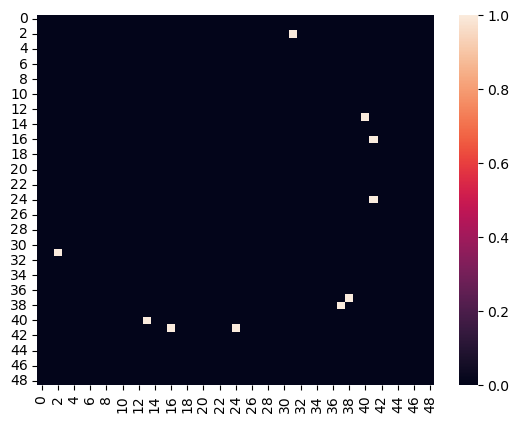

In [397]:
import seaborn as sns 
sns.heatmap(test)
test_motif = interaction_matrix_to_motif(test, list_id=list_id)
test_motif

In [398]:
(list_timestep == sorted(list_timestep)).sum(), len(list_timestep)

(np.int64(54541), 54541)

In [399]:
def stack_to_df_motif(stack, list_timestep, list_id): 
    list_motif = []
    for matrix in stack :
        list_motif.append(interaction_matrix_to_motif(matrix,list_id))
    return pd.DataFrame({"glob_sensor_DateTime" : list_timestep, "motif" : list_motif})

In [400]:
df_motif = stack_to_df_motif(stack_matrice, list_timestep, list_id)

In [401]:
from collections import Counter

counts_motif = Counter()
for motif in df_motif["motif"] : 
    components = motif.connected_components()
    for comp in components :
        counts_motif[comp] +=1 

In [402]:
list_connected_components = list(counts_motif.keys())

In [403]:
MAX_SIZE_CONNECTED = pd.Series([len(motif) for motif in list_connected_components]).max()

In [404]:
dict_motif_by_size = dict((i,[])  for i in range(MAX_SIZE_CONNECTED+1))

for comp in list_connected_components : 
    dict_motif_by_size[len(comp)].append(comp)

dict_motif_by_size

{0: [],
 1: [Motif( 3660 -- 3cfa, oriented : False),
  Motif( 366c -- 3d04, oriented : False),
  Motif( 3d01 -- 3d02, oriented : False),
  Motif( 3662 -- 3668, oriented : False),
  Motif( 3ceb -- 3cfd, oriented : False),
  Motif( 3cf3 -- 3d05, oriented : False),
  Motif( 3cf6 -- 3d08, oriented : False),
  Motif( 3cf8 -- 3d01, oriented : False),
  Motif( 366d -- 3ceb, oriented : False),
  Motif( 3663 -- 366a, oriented : False),
  Motif( 3667 -- 3d08, oriented : False),
  Motif( 3cf6 -- 3cf9, oriented : False),
  Motif( 3cf0 -- 3cf6, oriented : False),
  Motif( 3cf1 -- 3d08, oriented : False),
  Motif( 3cec -- 3cfc, oriented : False),
  Motif( 3665 -- 3cf2, oriented : False),
  Motif( 366d -- 3cf4, oriented : False),
  Motif( 3cea -- 3cfa, oriented : False),
  Motif( 365d -- 3cfa, oriented : False),
  Motif( 3cfe -- 3ce9, oriented : False),
  Motif( 3669 -- 3cfd, oriented : False),
  Motif( 366d -- 3d05, oriented : False),
  Motif( 3666 -- 3ceb, oriented : False),
  Motif( 365e -- 3cf1, 

In [405]:
motif_by_vaches = dict((vaches,[]) for vaches in list_id)
for motif in list_connected_components :
    for vache in motif.get_nodes() : 
        motif_by_vaches[vache].append(motif)

In [406]:
len(motif_by_vaches["3663"])

1119

In [407]:
df_counts_motif = pd.DataFrame({"motif" : counts_motif.keys(), "counts": counts_motif.values()})

In [408]:
MIN_NB_INTER = 5
df_multiple_inter = df_counts_motif[df_counts_motif["counts"] >= MIN_NB_INTER]
df_multiple_inter

,motif,counts
0,(3660 -- 3cfa),247
1,(366c -- 3d04),426
3,(3d01 -- 3d02),222
5,(3662 -- 3668),111
6,(3ceb -- 3cfd),392
...,...,...
21450,"(3cea -- 3cfe, 3cfe -- 3d0f)",14
21462,"(3cee -- 3cff, 3cee -- 3d08, 3cf0 -- 3cff)",5
21481,"(3cee -- 3cf0, 3cee -- 3cff, 3cf0 -- 3cff)",5
21511,"(365e -- 3d08, 3ced -- 3d08)",5


In [409]:
count_motif_without_single_edge = dict((k,counts_motif[k]) for k in counts_motif if len(k) > 1)
df_count_motif_without_single_edge = pd.DataFrame({"motif" : count_motif_without_single_edge.keys(), "counts": count_motif_without_single_edge.values()})

In [410]:
MIN_NB_INTER = 5
df_multiple_inter_wse = df_count_motif_without_single_edge[df_count_motif_without_single_edge["counts"] >= MIN_NB_INTER]

In [411]:
### Analyse voisins 3663
vache = "3663"


In [412]:
motif_by_vaches_wse = dict((vaches,[]) for vaches in list_id)
for motif in list_connected_components :
    if len(motif) == 1 : 
        continue
    for vache in motif.get_nodes() : 
        motif_by_vaches_wse[vache].append(motif)

In [413]:
len(motif_by_vaches_wse[vache])

2098

## Approche par masque sur les composantes connexes

L'objectif de cette partie est dans un premier temps de faire le tri dans l'ensemble des motifs connexes pour enlever les motifs qui apparaissent une seule fois dans tout le datasets et qui ne sont pas des motifs récurrents.

Les motifs qui apparaissent une seule fois dans le dataset ne sont pas des motifs intéressants car ils ne sont pas réprésentatifs de la dynamique sociale des vaches.
L'objectif est de sortir des motifs récurrents dans le sens où ces groupes se forment à des instants différents.


In [414]:
def count_fuzzy_sequences_of_ones(arr, max_gap=1):
    """
    Compte le nombre de séquences de 1 en considérant qu'une interruption 
    de `max_gap` zéros ne casse pas la continuité.

    Args:
        arr (np.array): Tableau 1D contenant des 0 et des 1.
        max_gap (int): Nombre maximum de 0 autorisés à l'intérieur d'une séquence de 1.

    Returns:
        int: Nombre de séquences considérées comme continues.
    """
    # Récupérer les indices où il y a des 1
    ones_indices = np.where(arr == 1)[0]

    if len(ones_indices) == 0:
        return 0  # Aucun 1 dans le tableau

    # Compter les groupes en vérifiant les écarts entre indices
    count = 1  # Au moins une séquence détectée
    for i in range(1, len(ones_indices)):
        if (ones_indices[i] - ones_indices[i - 1]) > (max_gap + 1):
            count += 1  # Nouvelle séquence détectée
    
    return count


In [415]:
def mat_stack_to_list_connected_components(stack, list_id) : 
    """Fonction qui à partir du stack de matrice d'adjacence permet de sortir la liste des composantes connexes à chaque time step

    Args:
        stack (np.nd_array): Stack des matrices d'adjacence
        list_id (list[str]): list des id des vaches

    Returns:
        list[list[Motif]]: Liste des composantes connexes à chaque timestep
    """
    list_connected = []
    for matrix in stack : 
        list_comp = interaction_matrix_to_motif(matrix,list_id).connected_components()
        list_connected.append(list_comp)
    return list_connected

In [416]:
list_connected_per_ts = mat_stack_to_list_connected_components(stack_matrice, list_id)

In [417]:
len(stack_matrice), len(list_connected_per_ts)

(54541, 54541)

In [418]:
def mask_connected_comp(motif, list_connected_per_ts):
    """Fonction qui permet de sortir le mask d'apparition d'un motif"""
    mask = []
    for list_comp in list_connected_per_ts : 
        if motif in list_comp :
            mask.append(1)
        else :
            mask.append(0)
    return np.array(mask)

In [419]:
from collections import Counter

counts_motif = Counter()
for motif in df_motif["motif"] : 
    components = motif.connected_components()
    for comp in components :
        counts_motif[comp] +=1 

In [420]:
len(counts_motif)

21520

In [421]:
print(f"Max counts : {counts_motif.most_common(1)[0][1]} | {counts_motif.most_common(1)[0][0]}")

Max counts : 900 | Motif( 3d03 -- 3d04, oriented : False)


In [422]:
counts_motif.most_common(10)

[(Motif( 3d03 -- 3d04, oriented : False), 900),
 (Motif( 3cff -- 3d06, oriented : False), 851),
 (Motif( 3cf0 -- 3cf7, oriented : False), 849),
 (Motif( 3cfe -- 3d01, oriented : False), 842),
 (Motif( 365e -- 3cf0, oriented : False), 803),
 (Motif( 3669 -- 3d04, oriented : False), 793),
 (Motif( 3667 -- 3ced, oriented : False), 746),
 (Motif( 3cfc -- 3cff, oriented : False), 718),
 (Motif( 3ced -- 3d06, oriented : False), 676),
 (Motif( 3cea -- 3cee, oriented : False), 672)]

In [423]:
# Conversion en DataFrame les counts des composantes connexes
df_counts_motif = pd.DataFrame({"motif" : counts_motif.keys(), "counts" : counts_motif.values()})

In [424]:
NB_MIN_INTER = 30

filtered_counts = df_counts_motif[df_counts_motif["counts"] >= NB_MIN_INTER]

[Text(31, 0, '31'),
 Text(61, 0, '61'),
 Text(91, 0, '91'),
 Text(121, 0, '121'),
 Text(151, 0, '151'),
 Text(181, 0, '181'),
 Text(211, 0, '211'),
 Text(241, 0, '241'),
 Text(271, 0, '271'),
 Text(301, 0, '301'),
 Text(331, 0, '331'),
 Text(361, 0, '361'),
 Text(391, 0, '391'),
 Text(421, 0, '421'),
 Text(451, 0, '451'),
 Text(481, 0, '481'),
 Text(511, 0, '511'),
 Text(541, 0, '541'),
 Text(571, 0, '571'),
 Text(601, 0, '601'),
 Text(631, 0, '631'),
 Text(661, 0, '661'),
 Text(691, 0, '691'),
 Text(721, 0, '721'),
 Text(751, 0, '751'),
 Text(781, 0, '781'),
 Text(811, 0, '811'),
 Text(841, 0, '841'),
 Text(871, 0, '871')]

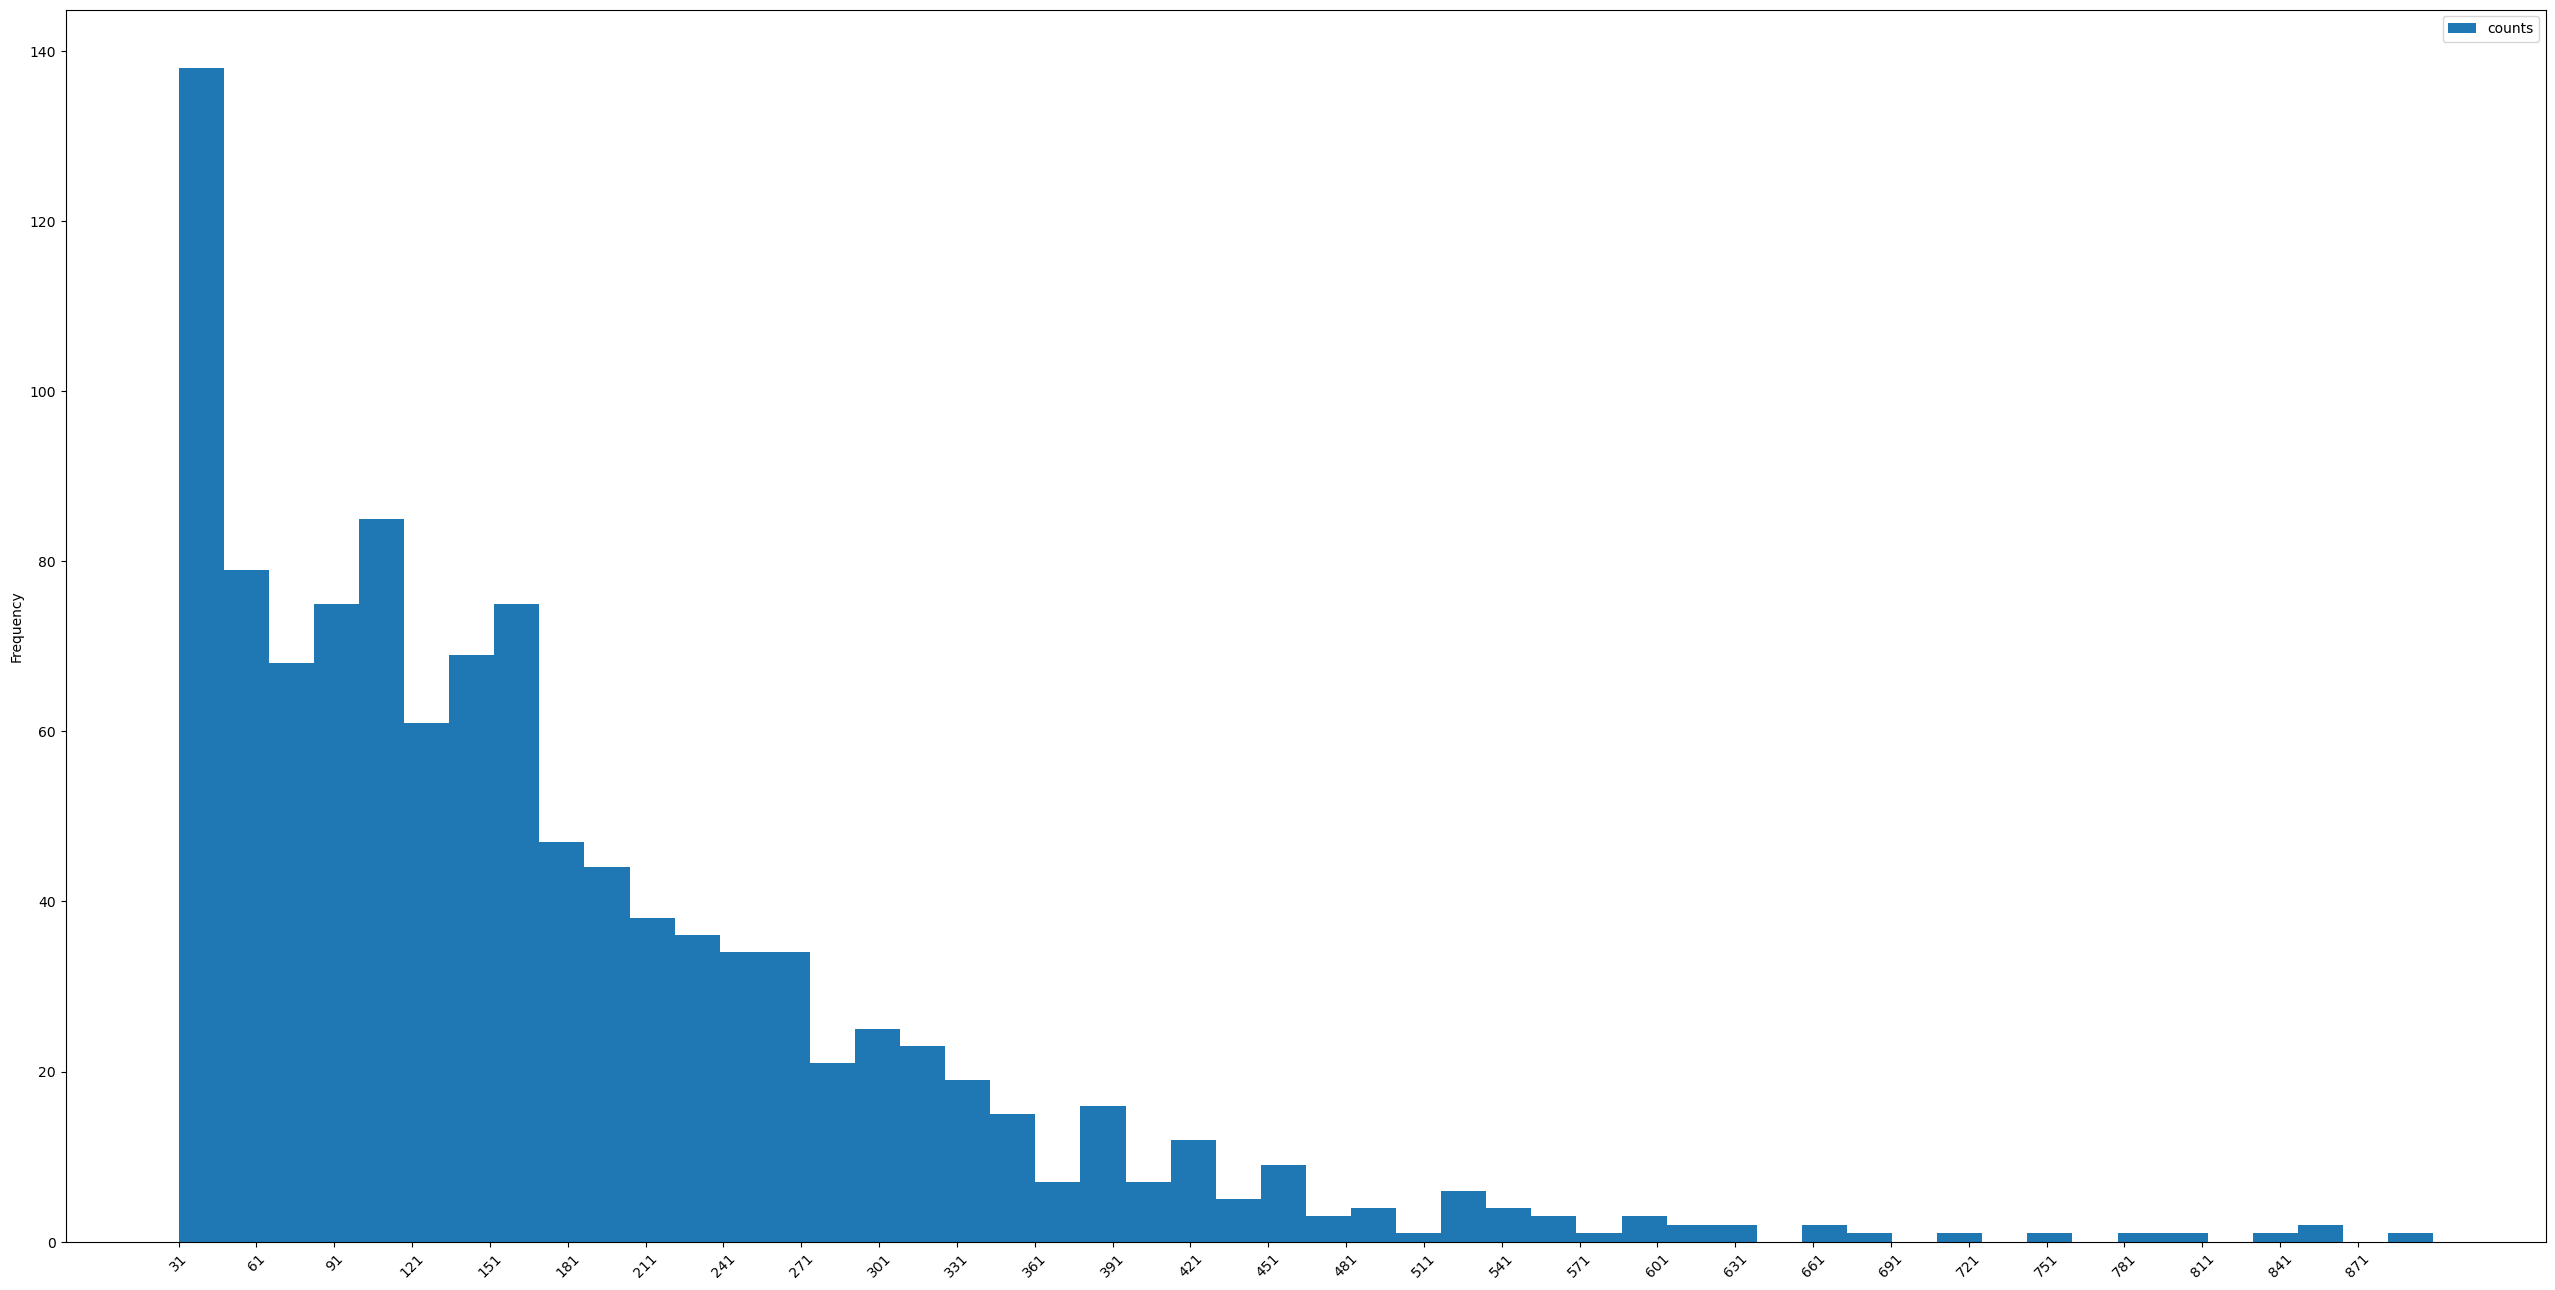

In [425]:
# filtered_counts.plot(kind="hist", bins = 50, figsize=(32,16))

# Créer l'histogramme
ax = filtered_counts.plot(kind="hist", bins = 50, figsize=(32,16))

# Régler les ticks de l'axe x
ax.set_xticks(np.arange(NB_MIN_INTER, filtered_counts["counts"].max() , 30))  # Ticks tous les 50
ax.set_xticklabels(np.arange(NB_MIN_INTER, filtered_counts["counts"].max() , 30), rotation=45)  # Labels avec rotation


In [426]:
list_connected_components = list(counts_motif.keys())

In [427]:
def masks_all_components(list_connected_components, list_connected_per_ts):
    masks = dict()
    for comp in tqdm(list_connected_components) : 
        masks[comp] = mask_connected_comp(comp, list_connected_per_ts)
    return masks

In [428]:
masks_all_comp = masks_all_components(list(filtered_counts["motif"]), list_connected_per_ts)

100%|██████████| 1082/1082 [01:24<00:00, 12.84it/s]


In [429]:
df_masks = pd.DataFrame({"motif" : masks_all_comp.keys(), "mask" : masks_all_comp.values})

In [430]:
MAX_GAP = 2

def fuzzy_count_all_masks(masks_all_comp, max_gap):
    fuzzy_counts = dict()
    for comp,mask in masks_all_comp.items(): 
        fuzzy_counts[comp] = count_fuzzy_sequences_of_ones(mask, max_gap)
    return fuzzy_counts

fuzzy_counts = fuzzy_count_all_masks(masks_all_comp, MAX_GAP)
df_fuzzy_counts = pd.DataFrame({"motif" : fuzzy_counts.keys(), "fuzzy_counts" : fuzzy_counts.values()})

In [437]:
MIN_LEN_COMP = 1 
filtered_fuzzy_counts = dict((k, fuzzy_counts[k]) for k in fuzzy_counts.keys() if len(k) >= MIN_LEN_COMP)
df_filtered_fuzzy_counts = pd.DataFrame({"motif" : filtered_fuzzy_counts.keys(), "fuzzy_counts" : filtered_fuzzy_counts.values()})
df_filtered_fuzzy_counts.sort_values(by="fuzzy_counts", ascending=False, inplace=True)

In [438]:
motif_filtered = df_filtered_fuzzy_counts["motif"]
motif_filtered

363                                        (3ced -- 3d06)
202                                        (3667 -- 3ced)
48                                         (3cf0 -- 3cf7)
73                                         (3669 -- 3d04)
824                                        (3cf0 -- 3cff)
                              ...                        
1069                         (3cef -- 3cf0, 3cf0 -- 3cfd)
1070                         (3666 -- 3cf4, 3cf3 -- 3cf4)
1048    (3ceb -- 3cfc, 3ceb -- 3d02, 3cfc -- 3d02, 3cf...
1063                         (3664 -- 3d02, 3d02 -- 3d04)
1006                         (3cfb -- 3d04, 3d04 -- 3d05)
Name: motif, Length: 1082, dtype: object

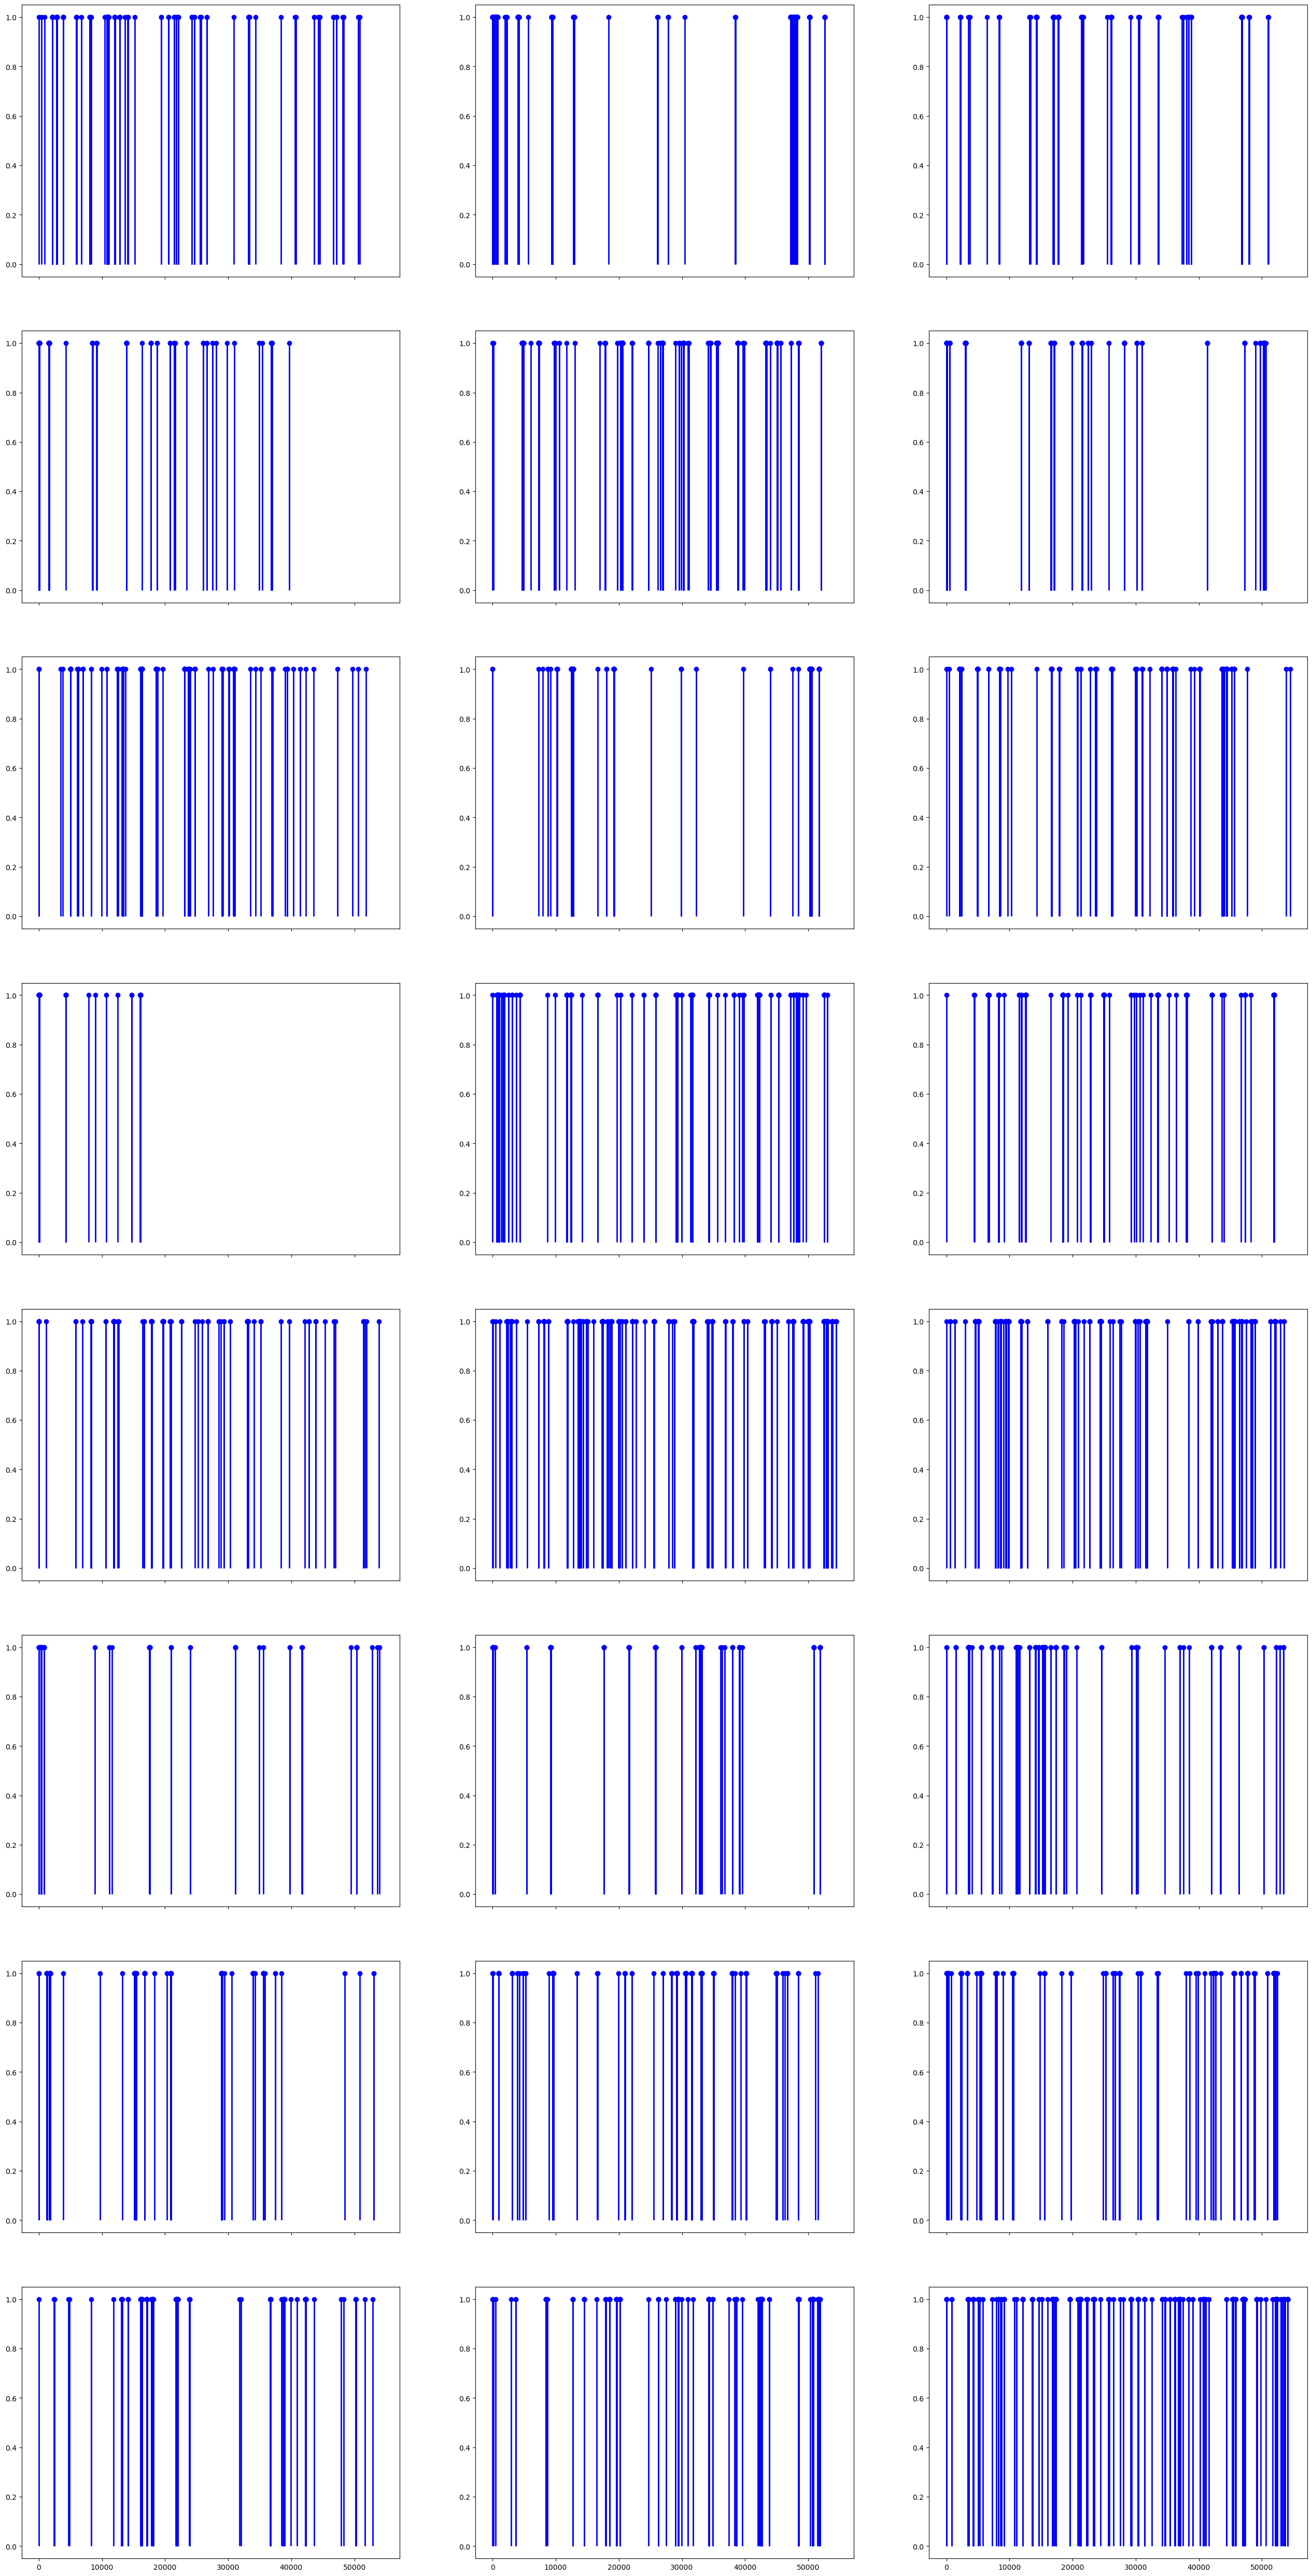

In [439]:
fig, axes = plt.subplots(8,3, figsize=(32,64), sharex=True)
NB_TIMESTEP = len(masks_all_comp[motif_filtered[0]])
ticks = np.arange(0,NB_TIMESTEP, 100)
for ind,ax in enumerate(axes.ravel()):
    comp = motif_filtered[ind]
    mask_comp = masks_all_comp[comp]
    indices = np.where(mask_comp == 1)[0]
    ax.vlines(indices, ymin=0, ymax=1, color='b', lw=2)
    ax.scatter(indices, np.ones_like(indices), color='b', marker='o', label="1 détecté")